In [184]:
import simpy
import numpy as np
from scipy.stats import expon
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor
from simpy import PriorityItem
import random

In [187]:
def seed_all(seed=42):
    random.seed(seed)
    np.random.seed(seed)

seed_all()

# Define simulation class, visualization and helper functions 

In [217]:
# Question 4: hyperexponential distribution for service time
def hyperexponential_rvs(mus: np.array, probs: np.array, n: int, random_state: int):
    """
        Generates n samples from a hyperexponential distribution with getting single sample x ~ exp(mus[i]) with probability probs[i].
    """

    choices = np.random.default_rng(random_state).choice(len(mus), size=n, p=probs)
    samples = np.zeros(n)

    for i, mu in enumerate(mus):
        mask = (choices == i)
        samples[mask] = expon.rvs(scale=1/mu, size=np.sum(mask), random_state=random_state)
    
    return samples

In [266]:
class MMN:
    def __init__(
        self, 
        rho: float, 
        mu: float, 
        num_servers_arr: np.array, 
        T: int, 
        random_state: int,
        queue_monitor_freq: float = None, 
        SJF: bool = False,
        deterministic_service_time: float = None,
        hyperexp_service_time_params: dict = None
    ):
        """
            rho: the load of the system.
            mu: the capacity of each of the N servers.
            num_servers_arr: an array of different number of servers to run simulation for, 
                i.e. [1,2] denotes simulation is run with the same samples when there are 1 servers and 2 servers.
            T: the time horizon to run the simulation for.
            random_state: random_state used for seeding.
            queue_monitor_freq: the frequency to monitor the queue for every time unit.
            SJF: If true, shortest job is first scheduled, otherwise, FIFO is used.
            deterministic_service_time: If not None, it is used as the deterministic service time.
            hyperexp_service_time_params: If not None, it is a dictionary containing:
                - 'mus': an array of rate parameters for the exponential distributions.
                - 'probs': an array of probabilities corresponding to each exponential distribution.
        """
    
        self.rho = rho
        self.mu = mu

        # Set the arrival rate self.lamb of the number of jobs into the system.
        if deterministic_service_time:
            self.lamb = rho * (num_servers_arr * deterministic_service_time)
        elif hyperexp_service_time_params:
            if 'mus' not in hyperexp_service_time_params or 'probs' not in hyperexp_service_time_params:
                raise ValueError("hyperexponential_service_time_params must contain 'mus' and 'probs' keys")
            
            self.mus = np.array(hyperexp_service_time_params['mus'])
            self.probs = np.array(hyperexp_service_time_params['probs'])
            self.lamb = rho * (num_servers_arr * (self.mus * self.probs).sum())
        else:
            self.lamb = rho * (num_servers_arr * mu)
    
        self.num_servers_arr = num_servers_arr
        self.T = T
        self.batch_sample_size = np.ceil(self.lamb*self.T*5).astype(int)
        self.num_diff_N = len(num_servers_arr)
        self.SJF = SJF
        self.queue_monitor_freq = queue_monitor_freq
        self.deterministic_service_time = deterministic_service_time
        self.hyperexp_service_time_params = hyperexp_service_time_params

        # Reproducibility params
        self.random_state_lamb = random_state
        self.random_state_mu = random_state + 1
        self.random_state_jump = 10^4

        # SimPy environment and resources
        self.env = simpy.Environment()
        self.servers_diff_N = [simpy.Resource(self.env, capacity=N) for N in num_servers_arr]
        if SJF:
            self.SJF_queue = simpy.PriorityStore(self.env)

        # Statistics
        self.waiting_times = [[] for _ in range(self.num_diff_N)]
        self.system_times = [[] for _ in range(self.num_diff_N)]
        if queue_monitor_freq:
            self.queue_monitor_interval = 1/queue_monitor_freq
            self.num_queue_monitor = T*queue_monitor_freq
            self.queue_lengths = np.zeros((self.num_diff_N, self.num_queue_monitor), dtype=np.uint32)

    def __job_arrival_FIFO(self, Ns_idx):
        """Generate job arrivals (FIFO)."""
        lamb = self.lamb[Ns_idx]
        batch_sample_size = self.batch_sample_size[Ns_idx]
        random_state_lamb = self.random_state_lamb
        random_state_mu = self.random_state_mu
        i = 0

        # Check if the service duration is random
        if not self.deterministic_service_time:
            while True:
                
                job_arrival_times = expon.rvs(scale=1/lamb, size=batch_sample_size, random_state=random_state_lamb)
                
                # Since service duration is random, we check for whether hyperexponential dist is used for service duration.
                if self.hyperexp_service_time_params:
                    service_durations = hyperexponential_rvs(self.mus, self.probs, batch_sample_size, random_state_mu)
                else:
                    service_durations = expon.rvs(scale=1/self.mu, size=batch_sample_size, random_state=random_state_mu)

                for job_arrival_time, service_duration in zip(job_arrival_times, service_durations):
                    yield self.env.timeout(job_arrival_time)
                    self.env.process(self.__job_process_FIFO(service_duration, Ns_idx))
                
                i+=1
                random_state_lamb = self.random_state_lamb+i*self.random_state_jump
                random_state_mu = self.random_state_mu+i*self.random_state_jump
        else:
            while True:
                
                job_arrival_times = expon.rvs(scale=1/lamb, size=batch_sample_size, random_state=random_state_lamb)

                for job_arrival_time in job_arrival_times:
                    yield self.env.timeout(job_arrival_time)
                    self.env.process(self.__job_process_FIFO(self.deterministic_service_time, Ns_idx))
                
                i+=1
                random_state_lamb = self.random_state_lamb+i*self.random_state_jump
                random_state_mu = self.random_state_mu+i*self.random_state_jump

    def __job_process_FIFO(self, service_duration, Ns_idx):
        """Process a single job (FIFO)."""
        arrival_time = self.env.now
        
        with self.servers_diff_N[Ns_idx].request() as request:
            yield request

            self.waiting_times[Ns_idx].append(self.env.now - arrival_time)

            yield self.env.timeout(service_duration)
            
            self.system_times[Ns_idx].append(self.env.now - arrival_time)

    def __job_arrival_SJF(self, Ns_idx):
        """Generate job arrivals (SJF)."""
        lamb = self.lamb[Ns_idx]
        batch_sample_size = self.batch_sample_size[Ns_idx]
        random_state_lamb = self.random_state_lamb
        random_state_mu = self.random_state_mu
        i = 0

        # Check if the service duration is random
        if not self.deterministic_service_time:
            while True:
                
                job_arrival_times = expon.rvs(scale=1/lamb, size=batch_sample_size, random_state=random_state_lamb)
                
                # Since service duration is random, we check for whether hyperexponential dist is used for service duration.
                if self.hyperexp_service_time_params:
                    service_durations = hyperexponential_rvs(self.mus, self.probs, batch_sample_size, random_state_mu)
                else:
                    service_durations = expon.rvs(scale=1/self.mu, size=batch_sample_size, random_state=random_state_mu)

                for job_arrival_time, service_duration in zip(job_arrival_times, service_durations):
                    yield self.env.timeout(job_arrival_time)
                    self.SJF_queue.put(PriorityItem(priority=service_duration, item=''))
                    self.env.process(self.__job_process_SJF(service_duration, Ns_idx))
                
                i+=1
                random_state_lamb = self.random_state_lamb+i*self.random_state_jump
                random_state_mu = self.random_state_mu+i*self.random_state_jump
        else:
            while True:
                
                job_arrival_times = expon.rvs(scale=1/lamb, size=batch_sample_size, random_state=random_state_lamb)

                for job_arrival_time in job_arrival_times:
                    yield self.env.timeout(job_arrival_time)
                    self.SJF_queue.put(PriorityItem(priority=service_duration, item=''))
                    self.env.process(self.__job_process_SJF(self.deterministic_service_time, Ns_idx))
                
                i+=1
                random_state_lamb = self.random_state_lamb+i*self.random_state_jump
                random_state_mu = self.random_state_mu+i*self.random_state_jump
    
    def __job_process_SJF(self, service_duration, Ns_idx):
        """Process a single job (SJF)."""
        arrival_time = self.env.now
        
        with self.servers_diff_N[Ns_idx].request() as request:
            yield request
            yield self.SJF_queue.get()

            self.waiting_times[Ns_idx].append(self.env.now - arrival_time)

            yield self.env.timeout(service_duration)
            
            self.system_times[Ns_idx].append(self.env.now - arrival_time)

    def __monitor_queue(self):
        """Monitor queue length."""
        for t in range(self.num_queue_monitor):
            for Ns_idx in range(self.num_diff_N):
                self.queue_lengths[Ns_idx, t] = len(self.servers_diff_N[Ns_idx].queue)
            yield self.env.timeout(self.queue_monitor_interval)

    def run_simulation(self):
        """Run the simulation."""
        # Run the simulation for different N at once consequently.
        for Ns_idx in range(len(self.servers_diff_N)):
            if self.SJF:
                self.env.process(self.__job_arrival_SJF(Ns_idx))
            else:
                self.env.process(self.__job_arrival_FIFO(Ns_idx))
        
            if self.queue_monitor_freq:
                self.env.process(self.__monitor_queue())
    
            self.env.run(until=(Ns_idx+1)*self.T)

        result = {
            'avg_waiting_time': [np.mean(wt) for wt in self.waiting_times],
            'avg_system_time': [np.mean(st) for st in self.system_times],
            'waiting_times': self.waiting_times,
            'system_times': self.system_times
        }

        if self.queue_monitor_freq:
            result['avg_queue_length'] = np.mean(self.queue_lengths, axis=1)
            result['queue_lengths'] = self.queue_lengths

        return result

In [264]:
def run_multiple_simulations(
        num_runs, 
        rho, 
        mu, 
        num_servers_arr, 
        T, 
        random_state_offset=0,
        queue_monitor_freq=None, 
        SJF=False, 
        deterministic_service_time=None,
        hyperexp_service_time_params=None
    ):
    """Run multiple simulations and average the results."""

    seed_all()

    num_diff_N = len(num_servers_arr)

    results = {
        'avg_waiting_time': np.zeros(num_diff_N),
        'avg_system_time': np.zeros(num_diff_N),
        'waiting_times': [[] for _ in range(num_diff_N)],
        'system_times': [[] for _ in range(num_diff_N)]
    }

    if queue_monitor_freq:
        results['queue_lengths'] = np.zeros((num_diff_N, queue_monitor_freq*T))
        results['avg_queue_length'] = np.zeros(num_diff_N)

    MMNs = [MMN(
        rho=rho, 
        mu=mu, 
        num_servers_arr=np.array(num_servers_arr), 
        T=T, 
        random_state=random_state_offset+i,
        queue_monitor_freq=queue_monitor_freq, 
        SJF=SJF, 
        deterministic_service_time=deterministic_service_time,
        hyperexp_service_time_params=hyperexp_service_time_params
    ) for i in range(num_runs)]

    def run_simulation(index):
        return MMNs[index].run_simulation()

    results_diff_runs = None

    # We use random_state to seed parallel programming
    with ThreadPoolExecutor() as ex:
        results_diff_runs = \
            list(ex.map(run_simulation, range(num_runs)))

    for sim_res in results_diff_runs:
        for key in results:
            if key.startswith('avg_') or key == 'queue_lengths':
                results[key] += sim_res[key]
            else:
                for i in range(len(num_servers_arr)):
                    results[key][i].extend(sim_res[key][i])

    for key in results:
        if key.startswith('avg_') or key == 'queue_lengths':
            results[key] /= num_runs

    return results

In [ ]:
def format_list(lst):
    return '[' + ', '.join(f'{x:.2f}' if isinstance(x, float) else str(x) for x in lst) + ']'

def plot_statistics(
        results, 
        num_servers_arr, 
        rho, 
        mu, 
        T, 
        num_runs, 
        n_bins=50, 
        edge_color=None, 
        edge_width=0.1, 
        SJF=False, 
        deterministic_service_time=None, 
        hyperexp_service_time_params=None
    ):

    mode = 'FIFO'
    num_col = 2
    mu_str = f'mu = {mu}'
    
    if SJF:
        mode = 'SJF'
    if 'queue_lengths' in results:
        num_col = 3
    if deterministic_service_time:
        mu_str = f'mu = {deterministic_service_time}'
        mode += ', MDN'
    else:
        mode += ', MMN'

    if hyperexp_service_time_params:
        if 'mus' not in hyperexp_service_time_params or 'probs' not in hyperexp_service_time_params:
            raise ValueError("hyperexponential_service_time_params must contain 'mus' and 'probs' keys")
        
        mus = np.array(hyperexp_service_time_params['mus'])
        probs = np.array(hyperexp_service_time_params['probs'])

        mode += ', hyperexp service'
        mu_str = f'mus = {format_list(mus)} with probs = {format_list(probs)}'


    print(f'Average Waiting Times ({mode}):', [f'{waiting_time:.2f}' for waiting_time in results['avg_waiting_time']])
    print(f'Average System Times ({mode}):', [f'{system_time:.2f}' for system_time in results['avg_system_time']])

    fig, axs = plt.subplots(num_col, 1, figsize=(10, 15))

    # Waiting Time Plot
    for i in range(len(num_servers_arr)):
        axs[0].hist(results['waiting_times'][i], bins=n_bins, edgecolor=edge_color, alpha=0.5, label=f'Servers: {num_servers_arr[i]}', linewidth=edge_width)
    axs[0].set_title(f'Distribution of Waiting Times ({mode})\n(rho={rho}, {mu_str}, T={T}, runs={num_runs})')
    axs[0].set_xlabel('Waiting Time')
    axs[0].set_ylabel('Frequency')
    axs[0].legend()

    # System Time Plot
    for i in range(len(num_servers_arr)):
        axs[1].hist(results['system_times'][i], bins=n_bins, edgecolor=edge_color, alpha=0.5, label=f'Servers: {num_servers_arr[i]}', linewidth=edge_width)
    axs[1].set_title(f'Distribution of System Times ({mode})\n(rho={rho}, {mu_str}, T={T}, runs={num_runs})')
    axs[1].set_xlabel('System Time')
    axs[1].set_ylabel('Frequency')
    axs[1].legend()

    if 'queue_lengths' in results:
        print(f'Average Queue Lengths ({mode}):', [f'{length:.2f}' for length in results['avg_queue_length']])
    
        # Queue Length Plot
        for i in range(len(num_servers_arr)):
            axs[2].plot(results['queue_lengths'][i], label=f'Servers: {num_servers_arr[i]}')
        axs[2].set_title(f'Queue Length over Time ({mode})\n(rho={rho}, {mu_str}, T={T}, runs={num_runs})')
        axs[2].set_xlabel('Time')
        axs[2].set_ylabel('Queue Length')
        axs[2].legend()

    plt.tight_layout()
    plt.show()

# Question 2

In [257]:
num_servers_arr = [1,2,4]
rho=0.9
mu=1
T=1000
num_runs=10

results_FIFO = run_multiple_simulations(num_runs=num_runs, rho=rho, mu=mu, num_servers_arr=np.array(num_servers_arr), T=T)

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


Average Waiting Times (FIFO, MMN): ['4.90', '2.30', '1.00']
Average System Times (FIFO, MMN): ['5.87', '3.27', '1.98']


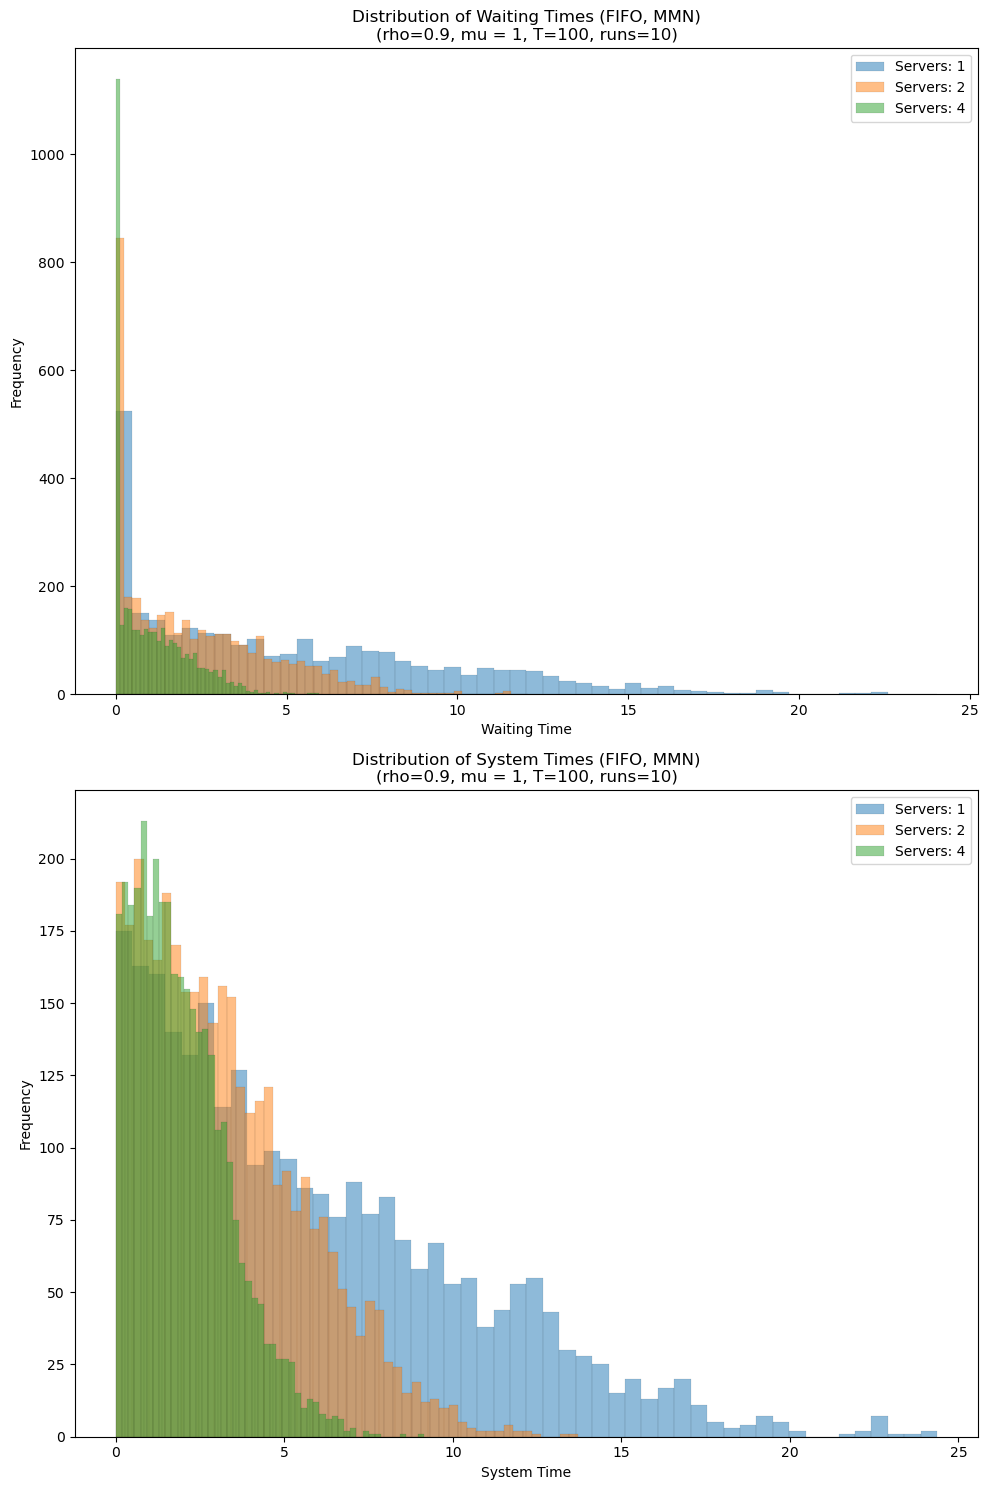

In [238]:
plot_statistics(results_FIFO, num_servers_arr, rho, mu, T, num_runs, edge_color='black')

# Question 3

In [267]:
num_servers_arr = [1,2,4]
rho=0.9
mu=1
T=1000
num_runs=10
SJF=True

results_SJF = run_multiple_simulations(num_runs=num_runs, rho=rho, mu=mu, num_servers_arr=np.array(num_servers_arr), T=T, SJF=SJF)

Average Waiting Times (SJF, MMN): ['9.11', '4.29', '1.98']
Average System Times (SJF, MMN): ['10.10', '5.28', '2.98']


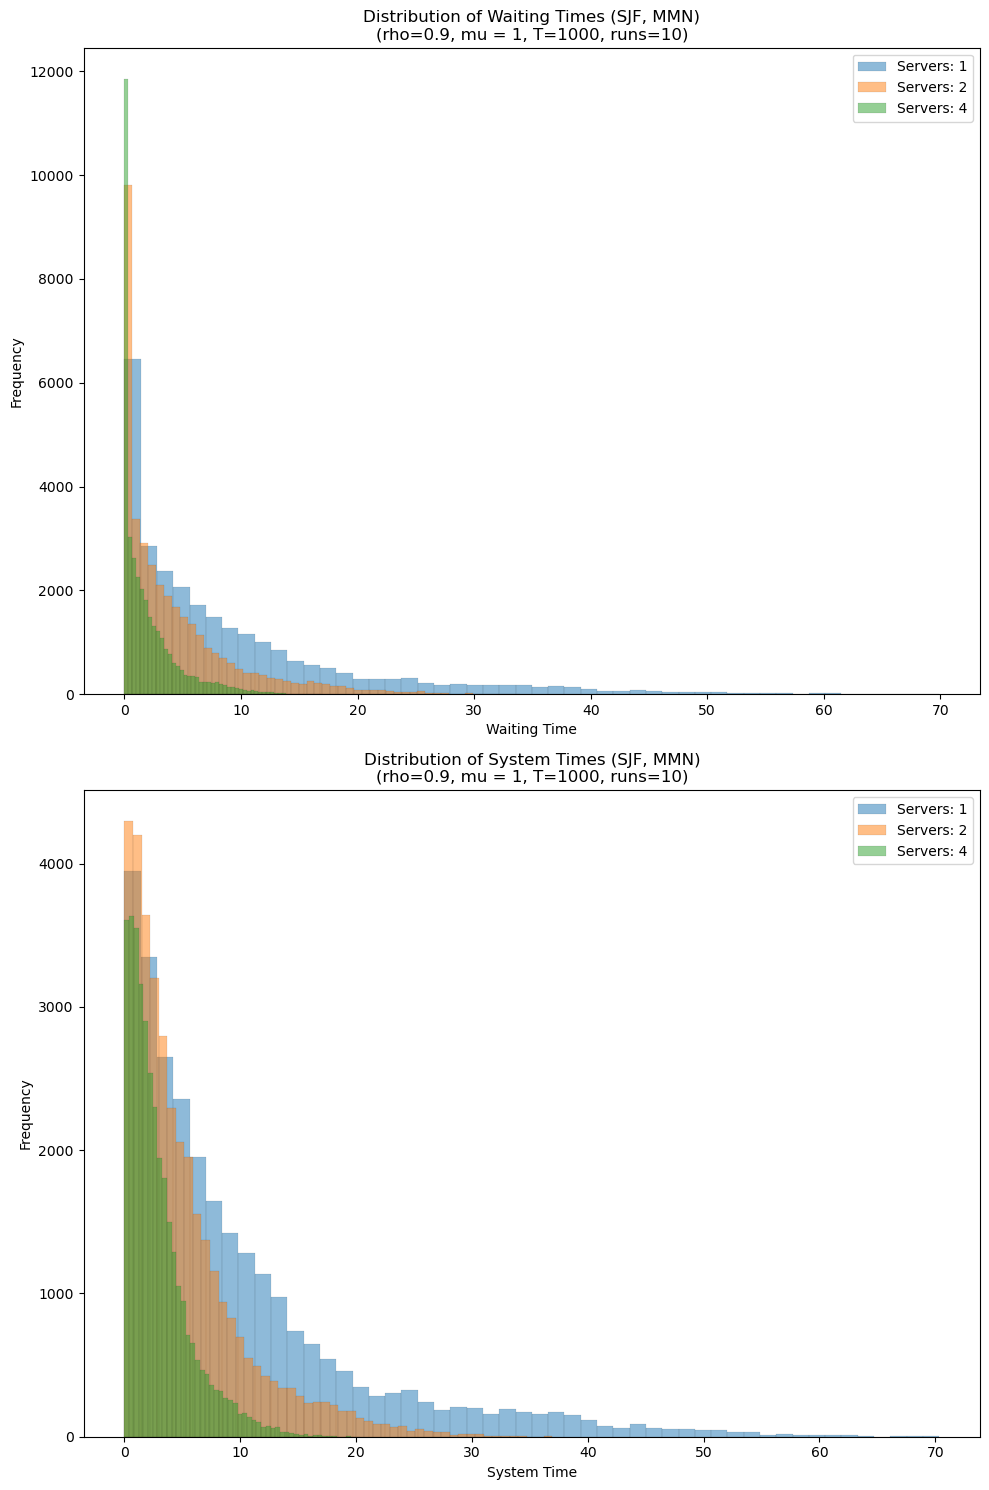

In [268]:
plot_statistics(results_SJF, num_servers_arr, rho, mu, T, num_runs, edge_color='black', SJF=SJF)

# Question 4

## MDN

In [261]:
num_servers_arr = [1,2,4]
rho=0.9
mu=None
T=100
num_runs=5
SJF=True
deterministic_service_time=1

results_MDN = run_multiple_simulations(num_runs=num_runs, rho=rho, mu=mu, num_servers_arr=np.array(num_servers_arr), T=T, deterministic_service_time=deterministic_service_time)

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


Average Waiting Times (FIFO, MDN): ['3.86', '1.92', '0.89']
Average System Times (FIFO, MDN): ['4.87', '2.92', '1.88']


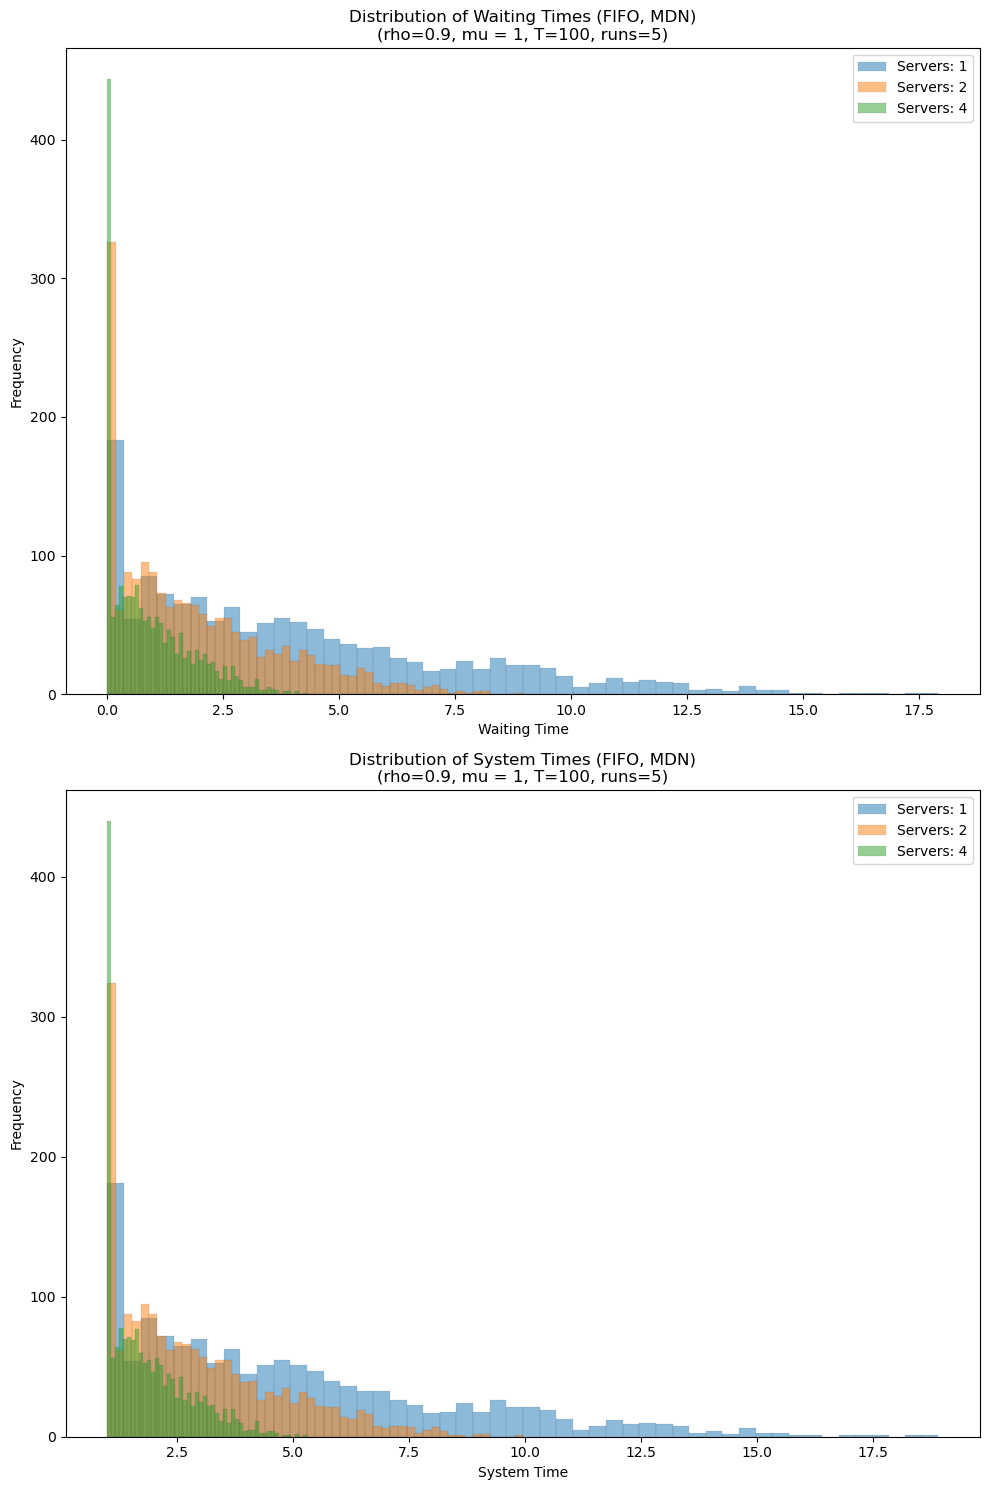

In [246]:
plot_statistics(results_MDN, num_servers_arr, rho, mu, T, num_runs, edge_color='black', deterministic_service_time=deterministic_service_time)

## Hyperexponential service time

Lambda here is calculated as self.lamb = rho * (num_servers_arr * (mus * probs).sum())

In [263]:
num_servers_arr = [1,2,4]
rho=0.9
mu=None
T=1000
num_runs=5
SJF=True
hyperexp_service_time_params={
    'mus': [1, 5],
    'probs': [0.75, 0.25]
}

results_MDN = run_multiple_simulations(num_runs=num_runs, rho=rho, mu=mu, num_servers_arr=np.array(num_servers_arr), T=T, hyperexp_service_time_params=hyperexp_service_time_params)

0
0
0
0
0
0
0
0
0
0
00

0
0
0


Average Waiting Times (FIFO, MMN, hyperexp service): ['45.50', '30.62', '15.07']
Average System Times (FIFO, MMN, hyperexp service): ['46.15', '31.29', '15.73']


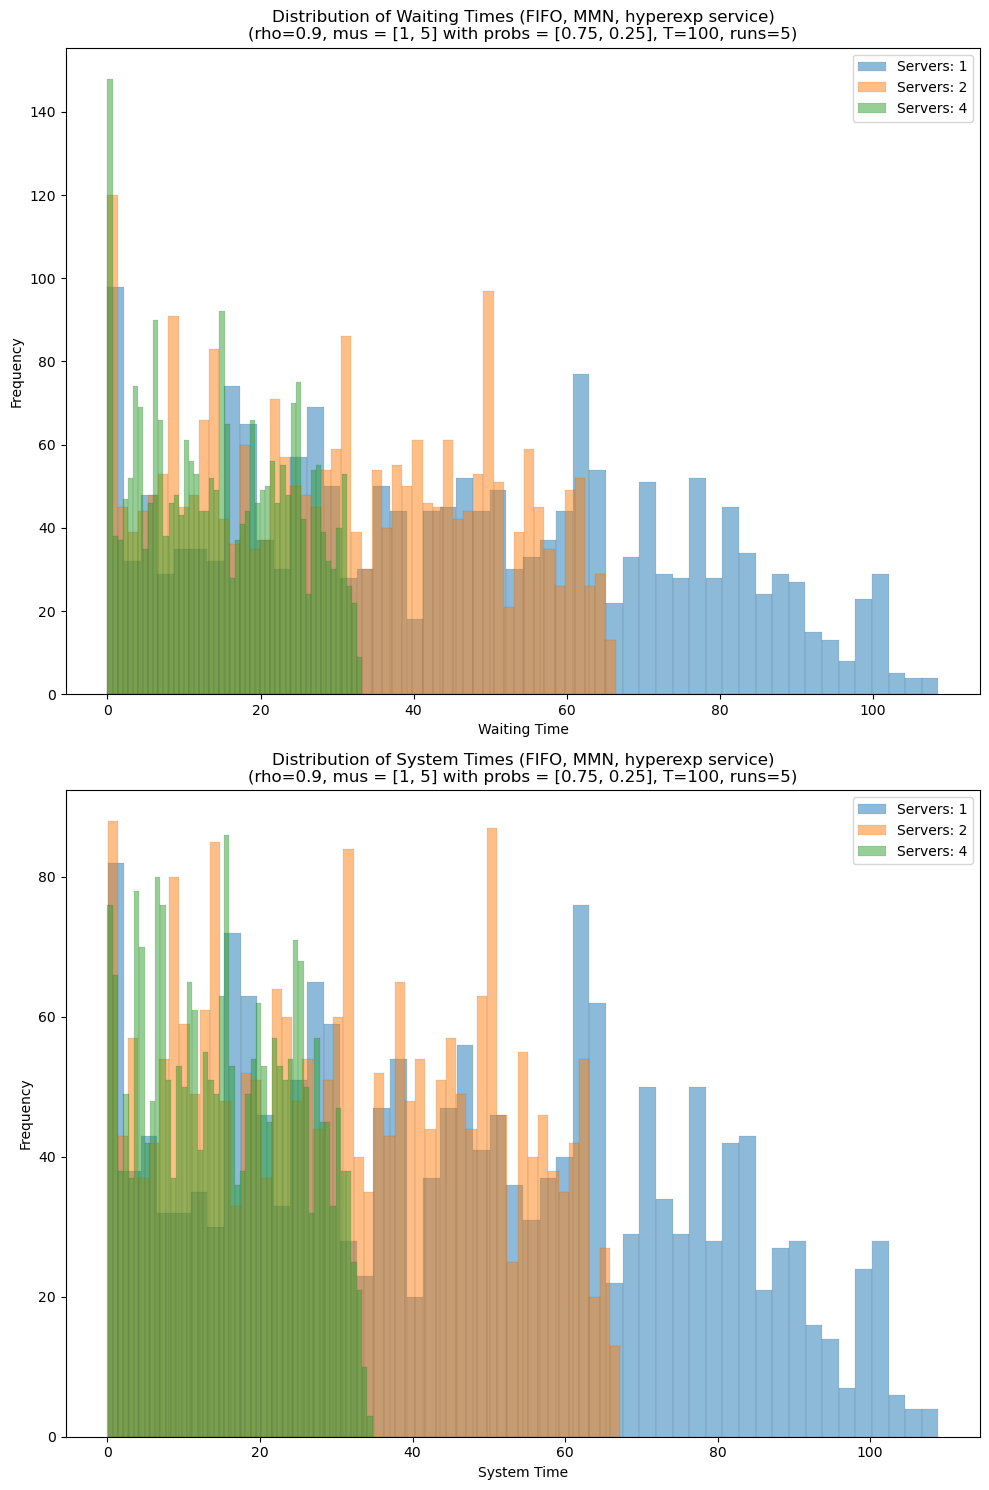

In [252]:
plot_statistics(results_MDN, num_servers_arr, rho, mu, T, num_runs, edge_color='black', hyperexp_service_time_params=hyperexp_service_time_params)